# Homework #2: Titanic Analysis
Submitted by:

**GROUP 2**
- CABALLA, John Allen C.
- CHAVEZ, Ruiz Lorenzo B.
- GAMMAD, Alyanna Marrielle C.
- MEJIA, Jo-Anne April P.
- PANUGAN, Ria Juvica M.

## Loading Packages

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import missingno as msno
import shap
import eli5

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
from eli5.sklearn import PermutationImportance


## Load Titanic Dataset

In [67]:
titanic_df = pd.read_csv("data/train.csv", index_col="PassengerId")
train_shape = titanic_df.shape
display(titanic_df.head())
print(f"Entries: {train_shape[0]}\nFeatures: {train_shape[1]}")

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Entries: 891
Features: 11


## Data Preprocessing

In [68]:
# initial dtypes of each column
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


We observe that cabin is mostly made up of nulls. We also see from the preview of the data that while it is classed as object, it is actually string type, which cannot be categorized and does not contribute much to the outcome. Thus, this column should not be used for analyses.

We also notice that Age has a significant number of nulls.

In [69]:
titanic_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Checking null values

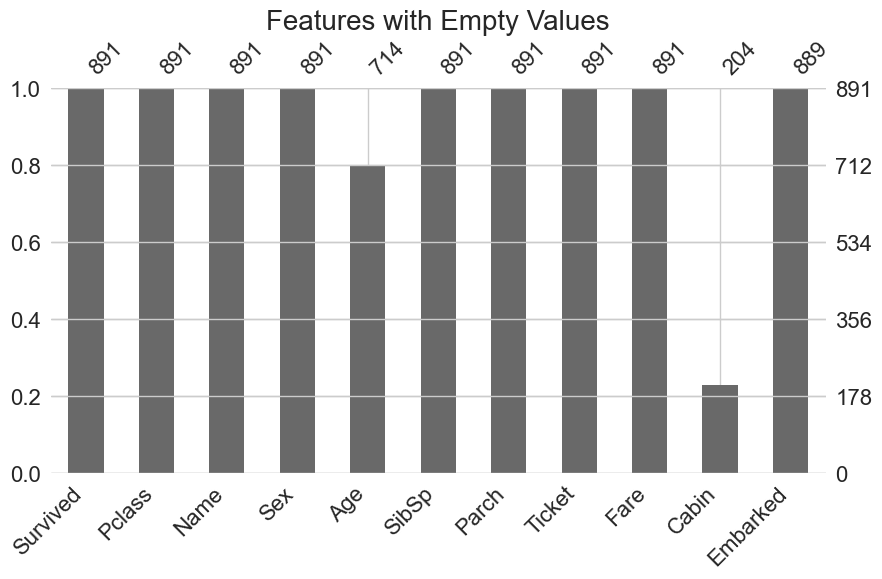

In [70]:
#  null entries
fig, ax = plt.subplots(figsize=(10,5))
msno.bar(titanic_df, ax=ax)
ax.set_title("Features with Empty Values",
             fontdict={"fontsize": 20})
plt.savefig("viz/null_before.png", bbox_inches="tight")

### Checking unique values

In [71]:
# no. of unique values in each column
titanic_df.nunique()

Survived      2
Pclass        3
Name        891
Sex           2
Age          88
SibSp         7
Parch         7
Ticket      681
Fare        248
Cabin       147
Embarked      3
dtype: int64

### Checking duplicated values

In [72]:
#  check if there are duplicated passengers
count_duplicated_passengers = titanic_df.Name.duplicated().sum()
print(f"There are {count_duplicated_passengers} duplicated passengers in this log.")

There are 0 duplicated passengers in this log.


### Data cleaning

#### Dealing with null values

##### Feature #1: Embarked

Embarked was imputed using the mode as there were only 3 missing values and it is most likely that it would follow the values of the most frequent S.

In [73]:
#  check entries with null Embarked values
null_embarked = titanic_df.Embarked.isna()
display(titanic_df[null_embarked].head())
print(f"There are {null_embarked.sum()} passengers with no embarked specified.")
print(f"That is {(null_embarked.sum() / titanic_df.shape[0]) * 100:.2f}% of the entire titanic_df with no specified embarked")

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


There are 2 passengers with no embarked specified.
That is 0.22% of the entire titanic_df with no specified embarked


##### Feature #2: Age

In [74]:
#  check entries with null Age values
null_age = titanic_df.Age.isna()
display(titanic_df[null_age].head())
print(f"There are {null_age.sum()} passengers with no age specified.")
print(f"That is {(null_age.sum() / titanic_df.shape[0]) * 100:.2f}% of the entire titanic_df with no specified age")

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q


There are 177 passengers with no age specified.
That is 19.87% of the entire titanic_df with no specified age


##### Feature #3: Cabin

In [75]:
#  check entries with null Cabin values
null_cabin = titanic_df.Cabin.isna()
display(titanic_df[null_cabin].head())
print(f"There are {null_cabin.sum()} passengers with no cabin specified.")
print(f"That is {(null_cabin.sum() / titanic_df.shape[0]) * 100:.2f}% of the entire titanic_df with no specified cabin ID")

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


There are 687 passengers with no cabin specified.
That is 77.10% of the entire titanic_df with no specified cabin ID


##### Cleaning null values

In [76]:
def lowercase_columns(df):
    df.columns = df.columns.str.lower()
    return df

def embarked_solution(df):
    df['embarked'] = df['embarked'].fillna(df['embarked'].mode()[0])
    return df

def age_solution(df):
    #  checking possible titles
    df['title'] = df['name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())

    # making Miss into Ms
    df['title'] = df['title'].replace('Miss','Ms')

    grouped_age_df = df[["pclass", "sex", "title", "age"]].copy()
    df["age"] = grouped_age_df.groupby(['pclass','sex','title'])["age"].transform(lambda x: x.fillna(x.median()))
    return df

def cabin_solution(df):
    return df.drop(columns=["cabin"])

def categorical_encoding(df):
    #  label encoding
    df['sex'] = df['sex'].replace(['female','male'],[0,1])
    
    #  one-hot encoding
    df = pd.get_dummies(data=df, columns=["embarked"])
    return df

def cleaning(df):
    df = lowercase_columns(df)
    df = embarked_solution(df)
    df = age_solution(df)
    df = cabin_solution(df)
    return df

In [77]:
titanic_df = cleaning(titanic_df)
titanic_df.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked,title
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Ms
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr


##### Null values after cleaning

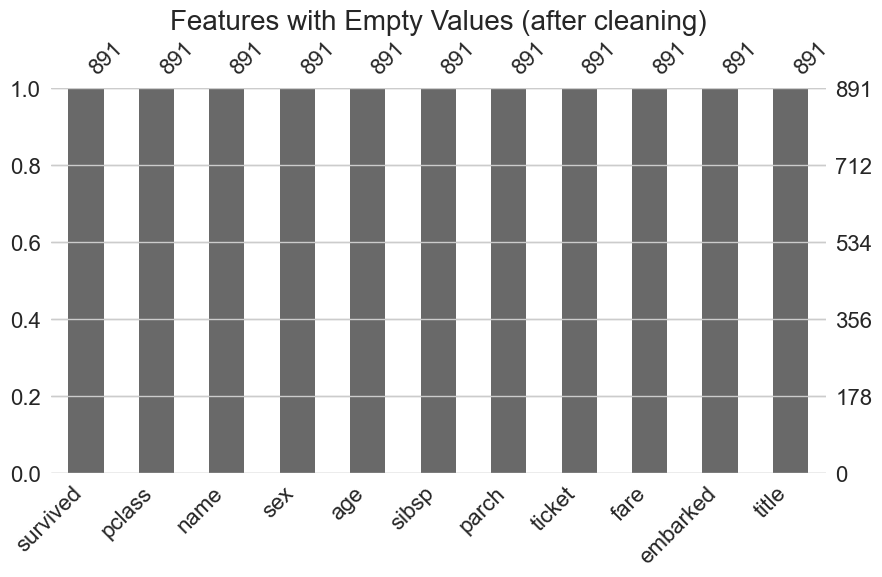

In [78]:
#  check if there are no more empty values
#  null entries
fig, ax = plt.subplots(figsize=(10,5))
msno.bar(titanic_df, ax=ax)
ax.set_title("Features with Empty Values (after cleaning)",
             fontdict={"fontsize": 20})
plt.savefig("viz/null_after.png", bbox_inches="tight")

## Exploratory Data Analysis

### Distribution of values in each feature

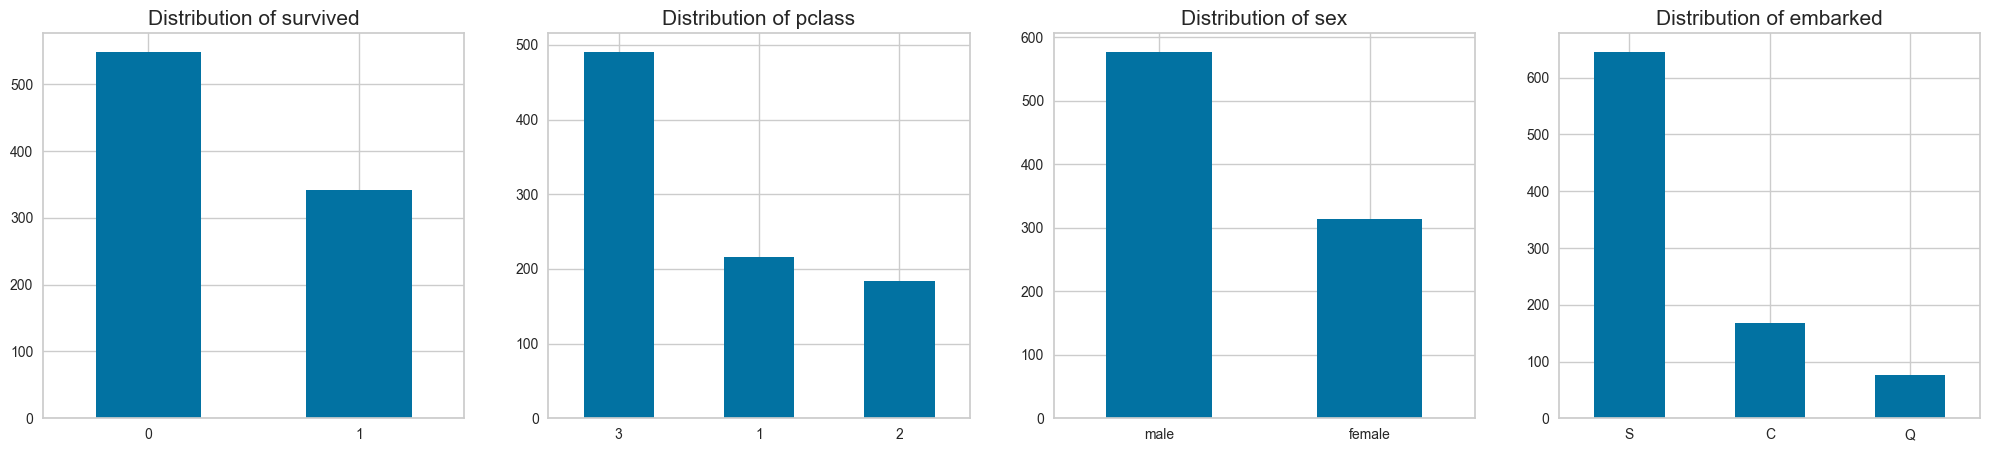

In [79]:
fig, axs = plt.subplots(1,4, figsize=(25,5))

bar_list = ["survived", 
            "pclass",
            "sex",
            "embarked",]

for i, col in enumerate(bar_list):
    titanic_df[col].value_counts().plot(kind="bar",
                       ax=axs[i],
                       rot=0)
    axs[i].set_title(f"Distribution of {col}",
                     fontdict={"fontsize": 15})
    
plt.savefig("viz/categ_distribution.png",
            bbox_inches="tight")

Mean Age: 29.14
Median Age: 26.0

Mean Fare: 32.20
Median Fare: 14.45


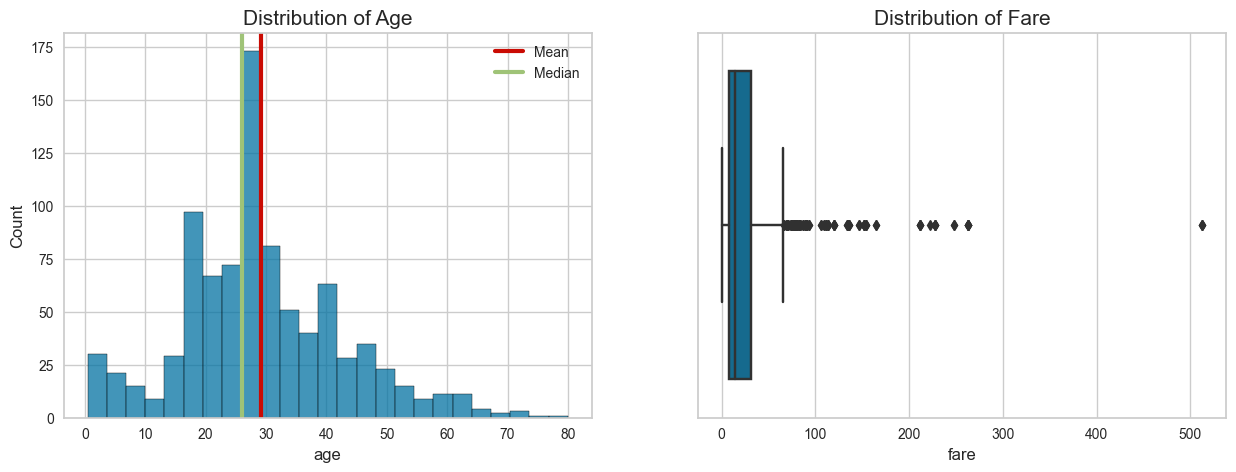

In [80]:
fig, axs = plt.subplots(1,2, figsize=(15,5))

sns.histplot(data=titanic_df,
             x="age",
             ax=axs[0])
axs[0].set_title("Distribution of Age",
                 fontdict={"fontsize": 15})
axs[0].axvline(x=titanic_df.age.mean(),
               linewidth=3, 
               color='r',
               label="Mean"
               )
axs[0].axvline(x=titanic_df.age.median(),
               linewidth=3, 
               color='g',
               label="Median"
               )
axs[0].legend()

sns.boxplot(data=titanic_df,
            x="fare",
            ax=axs[1])
axs[1].set_title("Distribution of Fare",
                 fontdict={"fontsize": 15})

plt.savefig("viz/num_distribution.png",
            bbox_inches="tight")

print(f"Mean Age: {titanic_df.age.mean():.2f}")
print(f"Median Age: {titanic_df.age.median()}\n")
print(f"Mean Fare: {titanic_df.fare.mean():.2f}")
print(f"Median Fare: {titanic_df.fare.median():.2f}")

Survival rate of 1: 62.96%
Survival rate of 2: 47.28%
Survival rate of 3: 24.24%
Survival rate of female: 74.20%
Survival rate of male: 18.89%
Survival rate of C: 55.36%
Survival rate of Q: 38.96%
Survival rate of S: 33.90%


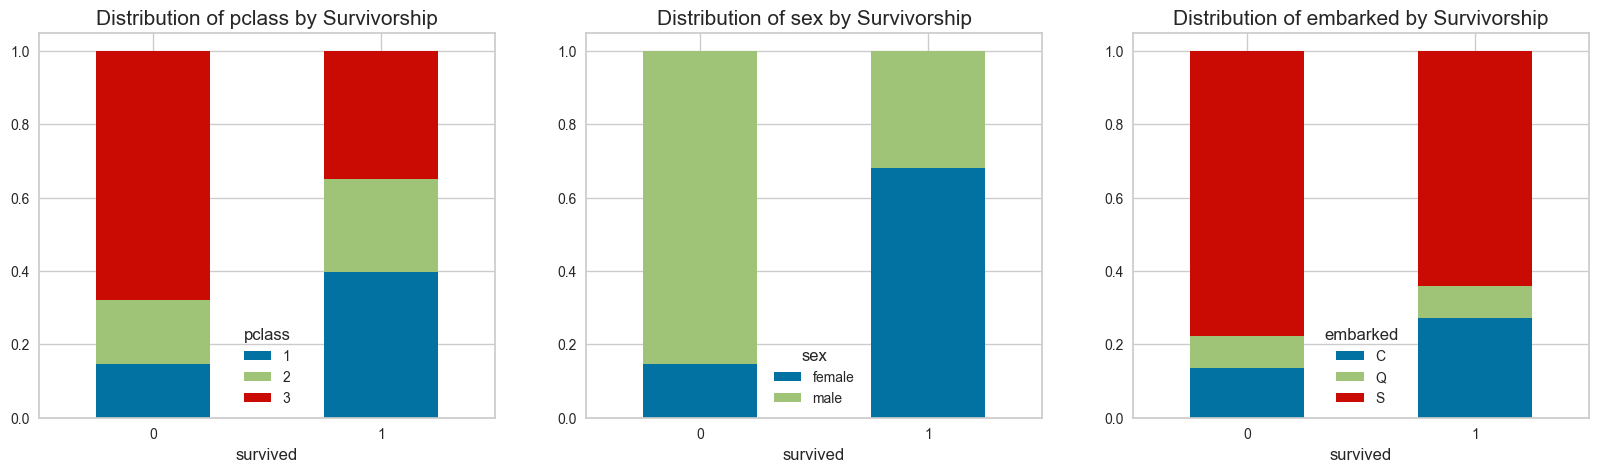

In [81]:
fig, axs = plt.subplots(1, 3, figsize=(20,5))

col_list = ["pclass",
            "sex",
            "embarked",]

for i, col in enumerate(col_list):
    pd.crosstab(titanic_df["survived"], titanic_df[col], normalize="index").plot.bar(stacked=True, ax=axs[i], rot=0)
    axs[i].set_title(f"Distribution of {col} by Survivorship",
                     fontdict={"fontsize": 15})

plt.savefig("viz/categ_dist_survivor.png",
            bbox_inches="tight")
    
for col in col_list:
    survival_rates = pd.crosstab(titanic_df["survived"], titanic_df[col], normalize="columns").loc[1]
    for category in survival_rates.index:
        print(f"Survival rate of {category}: {survival_rates[category] * 100:.2f}%")
    

mean               min          max      
sex          female       male female  male female  male
survived                                                
0         24.049383  30.789530   2.00  1.00   57.0  74.0
1         28.416309  27.418991   0.75  0.42   63.0  80.0

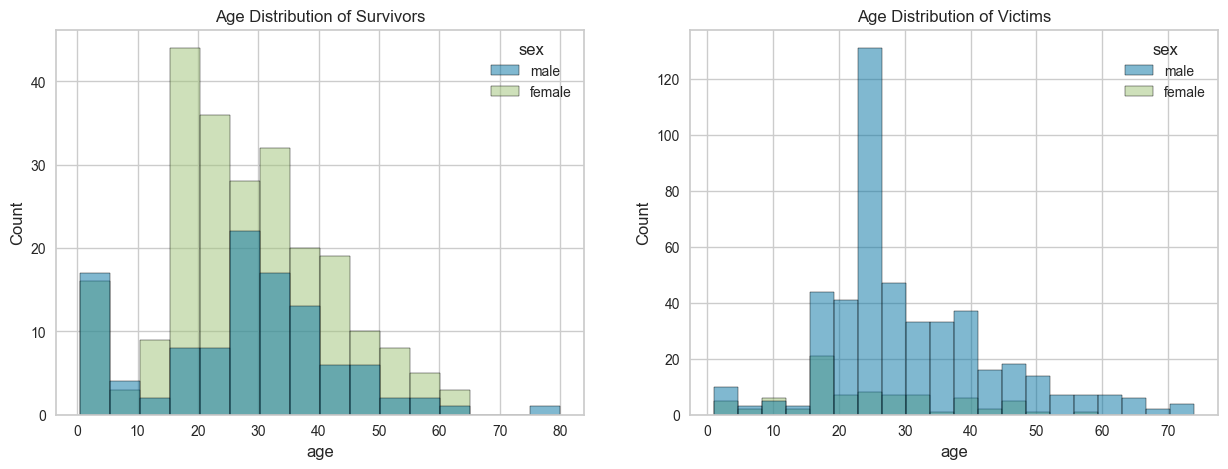

In [82]:
survivors = titanic_df.query("survived == 1")
victims = titanic_df.query("survived == 0")

fig, axs = plt.subplots(1,2, figsize=(15,5))

sns.histplot(data=survivors,
             x="age",
             hue="sex",
             ax=axs[0],
             hue_order=["male", "female"]
             )
axs[0].set_title("Age Distribution of Survivors")

sns.histplot(data=victims,
             x="age",
             hue="sex",
             ax=axs[1],
             hue_order=["male", "female"]
             )
axs[1].set_title("Age Distribution of Victims")

plt.savefig("viz/age_dist_survivor.png",
            bbox_inches="tight")

sex_numerical = pd.crosstab(titanic_df.survived, titanic_df.sex, titanic_df.age, aggfunc=[np.mean, min, max])
display(sex_numerical)

Survivors Mean & Median Fare: 48.40 | 26.00
Victims Mean & Median Fare: 22.12 | 10.50

pclass 1 Mean & Median Fare: 84.15 | 60.29
pclass 2 Mean & Median Fare: 20.66 | 14.25
pclass 3 Mean & Median Fare: 13.68 | 8.05


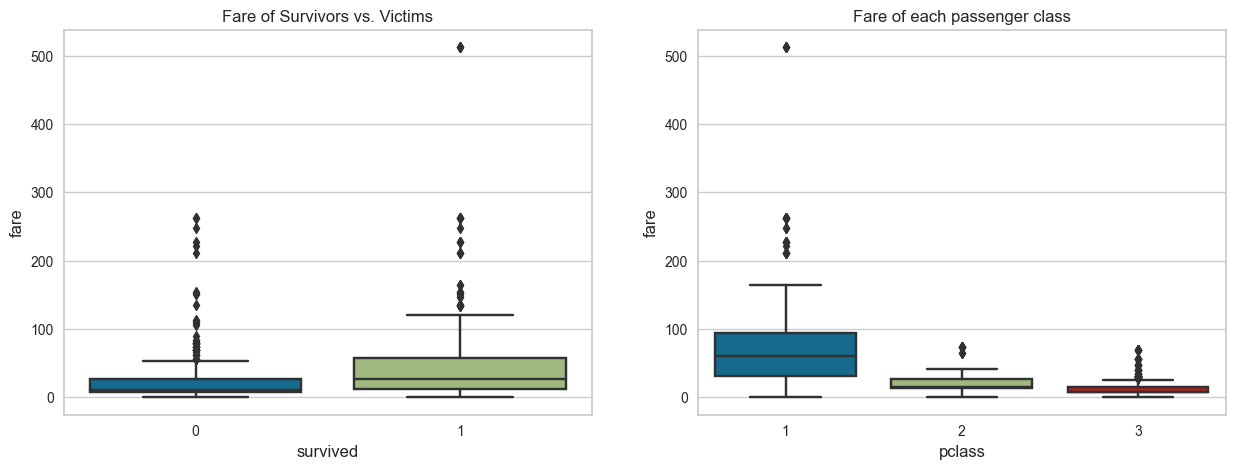

In [83]:
fig, axs = plt.subplots(1,2, figsize=(15,5))

sns.boxplot(data=titanic_df,
            x="survived", 
            y="fare",
            ax=axs[0])
axs[0].set_title("Fare of Survivors vs. Victims")

print(f"Survivors Mean & Median Fare: {titanic_df.query('survived==1')['fare'].mean():.2f} | {titanic_df.query('survived==1')['fare'].median():.2f}")
print(f"Victims Mean & Median Fare: {titanic_df.query('survived==0')['fare'].mean():.2f} | {titanic_df.query('survived==0')['fare'].median():.2f}\n")

sns.boxplot(data=titanic_df,
            x="pclass", 
            y="fare",
            ax=axs[1])
axs[1].set_title("Fare of each passenger class")

print(f"pclass 1 Mean & Median Fare: {titanic_df.query('pclass==1')['fare'].mean():.2f} | {titanic_df.query('pclass==1')['fare'].median():.2f}")
print(f"pclass 2 Mean & Median Fare: {titanic_df.query('pclass==2')['fare'].mean():.2f} | {titanic_df.query('pclass==2')['fare'].median():.2f}")
print(f"pclass 3 Mean & Median Fare: {titanic_df.query('pclass==3')['fare'].mean():.2f} | {titanic_df.query('pclass==3')['fare'].median():.2f}")

### Correlation 

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


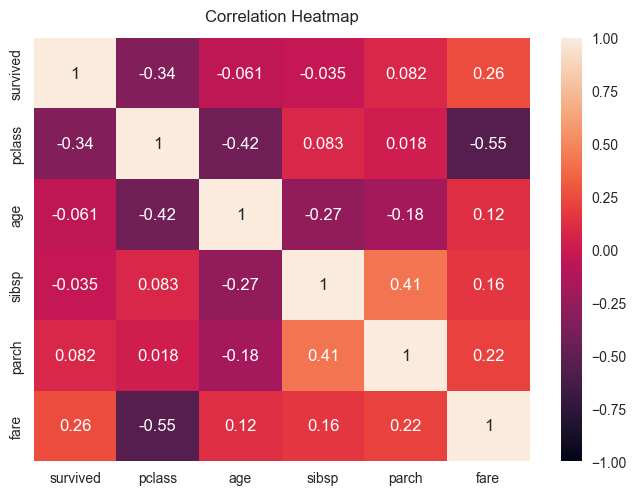

In [84]:
heatmap = sns.heatmap(titanic_df.corr(), 
                      vmin=-1, 
                      vmax=1, 
                      annot=True
                      )
heatmap.set_title("Correlation Heatmap", 
                  fontdict={'fontsize':12},
                  pad=12
                  )

plt.savefig("viz/corr_heatmap.png",
            bbox_inches="tight"
            )

By getting the absolute value of the correlation, we can see the strengths of each correlation coefficient <br>
According to **Juhari (2013)**, this is the basis for the strength value of a correlation coefficient: 
|**Absolute Value**|**Strength of correlation**|
|:----------------:|:-------------------------:|
|0.91-1.00|Very Strong|
|0.71-0.90|Strong|
|0.51-0.70|Moderate|
|0.31-0.50|Weak|
|0.01-0.30|Very Weak|
|0.00|No correlation|

Based on this table, we can determine the strength of the correlation coefficient such that, <br>
|**Correlation coefficient**|**Strength**|
|:-------------------------:|:----------:|
|n/a|Very Strong|
|embarked_S vs embarked_C|Strong|
|sex vs survived <br> fare vs pclass <br> embarked_S vs embarked_Q|Moderate|
|pclass vs survived <br> age vs pclass|Weak|
|age vs survived <br> fare vs survived <br> embarked_C vs survived <br> embarked_Q vs survived<br> embarked_S vs survived <br> companions vs survived <br>sex vs pclass <br>embarked_C vs pclass <br>embarked_Q vs pclass <br>embarked_S vs pclass <br>companions vs pclass <br>age vs sex <br>fare vs sex <br>  embarked_C vs sex <br> embarked_Q vs sex <br> emabrked_S vs sex <br> companions vs sex <br> fare vs age <br> ...|Very Weak|

## Feature Engineering

In [85]:
def categorical_encoding(df):
    #  label encoding
    df['sex'] = df['sex'].replace(['female','male'],[0,1])
    
    #  one-hot encoding
    df = pd.get_dummies(data=df, columns=["embarked"])
    return df

def companion_feature(df):
    df["companions"] = df.sibsp + df.parch
    df = df.drop(columns=["sibsp", "parch"])
    return df

def feature_engineering(df):
    df = categorical_encoding(df)
    df = companion_feature(df) 
    return df

### Feature Generation and Transformation

In [86]:
titanic_df = feature_engineering(titanic_df)
titanic_df.head()

,survived,pclass,name,sex,age,ticket,fare,title,embarked_C,embarked_Q,embarked_S,companions
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",1,22.0,A/5 21171,7.2500,Mr,0,0,1,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,PC 17599,71.2833,Mrs,1,0,0,1
3,1,3,"Heikkinen, Miss. Laina",0,26.0,STON/O2. 3101282,7.9250,Ms,0,0,1,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,113803,53.1000,Mrs,0,0,1,1
5,0,3,"Allen, Mr. William Henry",1,35.0,373450,8.0500,Mr,0,0,1,0


Survival rate for passengers with 0 companions: 30.35%
Survival rate for passengers with 1 companions: 55.28%
Survival rate for passengers with 2 companions: 57.84%
Survival rate for passengers with 3 companions: 72.41%
Survival rate for passengers with 4 companions: 20.00%
Survival rate for passengers with 5 companions: 13.64%
Survival rate for passengers with 6 companions: 33.33%
Survival rate for passengers with 7 companions: 0.00%
Survival rate for passengers with 10 companions: 0.00%


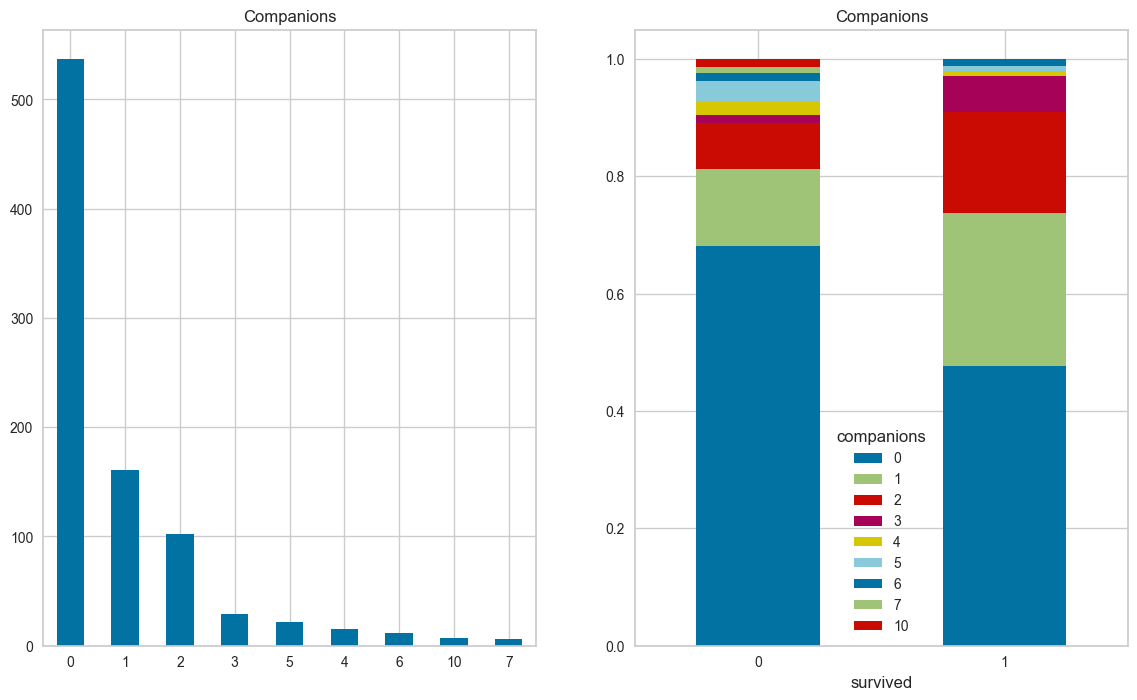

In [87]:
fig, axs = plt.subplots(1,2, figsize=(14,8))

titanic_df.companions.value_counts().plot.bar(ax=axs[0], rot=0,title="Companions")
pd.crosstab(titanic_df.survived, titanic_df.companions, normalize="index").plot.bar(stacked=True, ax=axs[1],rot=0,title="Companions")

survivor_companions = pd.crosstab(titanic_df.survived, titanic_df.companions, normalize="columns").loc[1] * 100

for idx in survivor_companions.index:
    print(f"Survival rate for passengers with {idx} companions: {survivor_companions[idx]:.2f}%")

## Machine Learning: Clustering and Prediction

### K-Means: Clustering passengers

#### Creating a copy of the original dataset

In [88]:
titanic_kmeans_df = titanic_df.copy()
titanic_kmeans_df.head()

,survived,pclass,name,sex,age,ticket,fare,title,embarked_C,embarked_Q,embarked_S,companions
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",1,22.0,A/5 21171,7.2500,Mr,0,0,1,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,PC 17599,71.2833,Mrs,1,0,0,1
3,1,3,"Heikkinen, Miss. Laina",0,26.0,STON/O2. 3101282,7.9250,Ms,0,0,1,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,113803,53.1000,Mrs,0,0,1,1
5,0,3,"Allen, Mr. William Henry",1,35.0,373450,8.0500,Mr,0,0,1,0


#### Feature selection: only numerical values

In [89]:
kmeans_df = titanic_kmeans_df.loc[:, titanic_kmeans_df.dtypes != "object"].copy()
kmeans_df = kmeans_df[kmeans_df.columns[1:]]
display(kmeans_df.head())
print(kmeans_df.shape)

,pclass,sex,age,fare,embarked_C,embarked_Q,embarked_S,companions
PassengerId,,,,,,,,
1,3,1,22.0,7.2500,0,0,1,1
2,1,0,38.0,71.2833,1,0,0,1
3,3,0,26.0,7.9250,0,0,1,0
4,1,0,35.0,53.1000,0,0,1,1
5,3,1,35.0,8.0500,0,0,1,0


(891, 8)


#### Scaling features

In [90]:
#  minmax scaling dataframe
minmax = MinMaxScaler()
scaled_kmeans = minmax.fit_transform(kmeans_df)
kmeans_df = pd.DataFrame(scaled_kmeans, columns=kmeans_df.columns)
kmeans_df.describe()

,pclass,sex,age,fare,embarked_C,embarked_Q,embarked_S,companions
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.654321,0.647587,0.360943,0.062858,0.188552,0.086420,0.725028,0.090460
std,0.418036,0.477990,0.169591,0.096995,0.391372,0.281141,0.446751,0.161346
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.000000,0.258608,0.015440,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.321438,0.028213,0.000000,0.000000,1.000000,0.000000
75%,1.000000,1.000000,0.456522,0.060508,0.000000,0.000000,1.000000,0.100000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Hyperparameter tuning: optimizing *k*

##### Using all features

In [91]:
#  initialize k array
k_list = [k for k in range(2,16)]


#  initialize silhouette coefficient array
silhouette_list = []

#  initialize davies-bouldin score array
db_list = []

data = kmeans_df.copy()     #  excludes port of embarkment 
for k in k_list:
    #  running kmeans algorithm
    kmeans = KMeans(n_clusters=k, 
                    random_state=10, 
                    n_init="auto").fit(data)
    clusters = kmeans.labels_
    
    #  for silhouette coeffiicent
    silhouette_coef = silhouette_score(data, clusters)
    silhouette_list.append(silhouette_coef)
    
    #  for davies-bouldin score
    db_score = davies_bouldin_score(data, clusters)
    db_list.append(db_score)

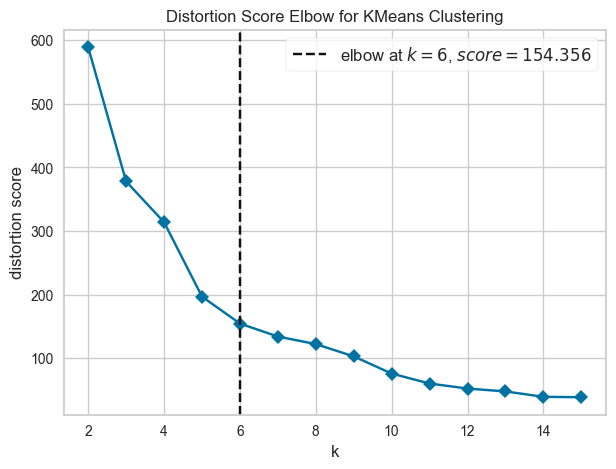

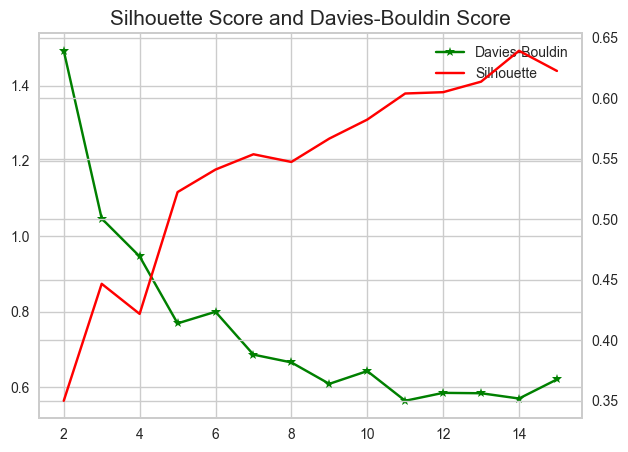

In [92]:
fig, ax1 = plt.subplots(figsize=(7,5))

visualizer = KElbowVisualizer(kmeans, 
                              k=(2,16), 
                              timings=False,
                              ax=ax1)

visualizer.fit(data)       
visualizer.show()       
plt.show()

fig, ax2 = plt.subplots(figsize=(7,5))


plot1 = ax2.plot(k_list, 
                 db_list, 
                 "*-", 
                 color="green", 
                 label="Davies-Bouldin")

ax3 = ax2.twinx()
plot2 = ax3.plot(k_list, 
                 silhouette_list, 
                 "x-", 
                 color="red", 
                 label="Silhouette")

plots = plot1+plot2
labels = [plot.get_label() for plot in plots]

ax2.set_title("Silhouette Score and Davies-Bouldin Score",
              fontdict={"fontsize": 15})
ax2.legend(plots, labels)

##### Using everything BUT Embarked

In [93]:
#  relevant features
relevant_features = ["pclass",
                     "sex",
                     "age",
                     "fare",
                     "companions"]

#  initialize k array
k_list = [k for k in range(2,16)]


#  initialize silhouette coefficient array
silhouette_list = []

#  initialize davies-bouldin score array
db_list = []

data = kmeans_df[relevant_features].copy()     #  excludes port of embarkment 
for k in k_list:
    #  running kmeans algorithm
    kmeans = KMeans(n_clusters=k, random_state=10, n_init="auto").fit(data)
    clusters = kmeans.labels_
    
    #  for silhouette coeffiicent
    silhouette_coef = silhouette_score(data, clusters)
    silhouette_list.append(silhouette_coef)
    
    #  for davies-bouldin score
    db_score = davies_bouldin_score(data, clusters)
    db_list.append(db_score)

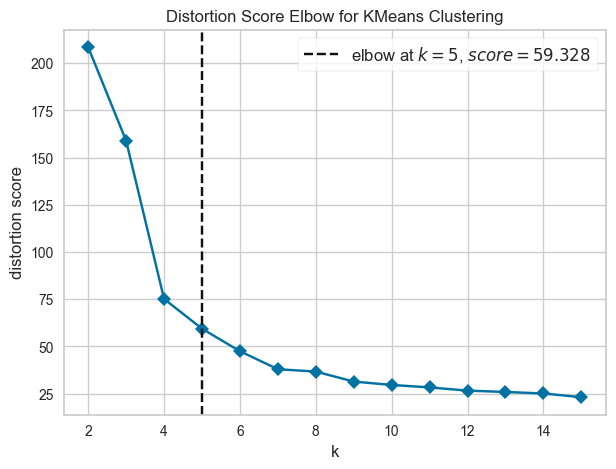

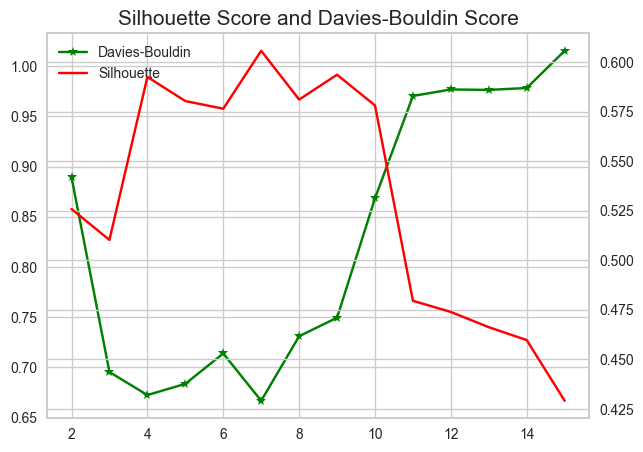

In [94]:
fig, ax1 = plt.subplots(figsize=(7,5))
visualizer = KElbowVisualizer(kmeans, k=(2,16), 
                              timings=False, 
                              ax=ax1)
visualizer.fit(data)       
visualizer.show()   
plt.show()

fig, ax2 = plt.subplots(figsize=(7,5))
plot1 = ax2.plot(k_list, 
                db_list, 
                "*-", 
                color="green", 
                label="Davies-Bouldin")

ax3 = ax2.twinx()
plot2 = ax3.plot(k_list, 
                 silhouette_list, 
                 "x-", 
                 color="red", 
                 label="Silhouette")

plots = plot1+plot2
labels = [plot.get_label() for plot in plots]

ax2.set_title("Silhouette Score and Davies-Bouldin Score",
              fontdict={"fontsize": 15})
plt.savefig("viz/db_s.png",
            bbox_inches="tight")
ax2.legend(plots, labels)

#### KMeans implementation

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


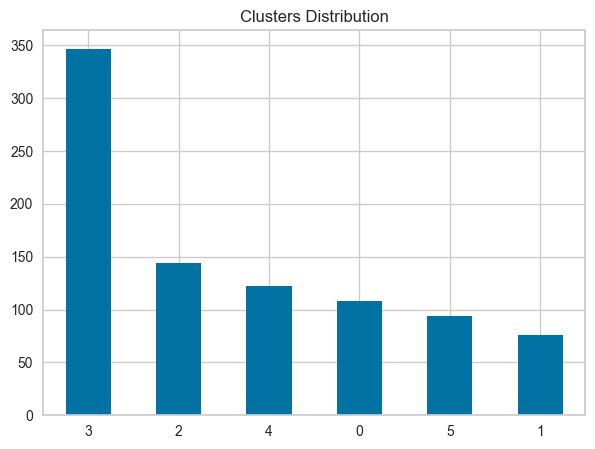

In [95]:
#  fitting the KMeans model to the data
k = 6
kmeans = KMeans(n_clusters=k, 
                random_state=10).fit(data)
clusters = kmeans.labels_

#  add clusters to titanic_kmeans_df
titanic_kmeans_df["cluster"] = clusters

titanic_kmeans_df.cluster.value_counts().plot.bar(rot=0, 
                                                  title="Clusters Distribution", 
                                                  figsize=(7,5))
plt.savefig("viz/cluster_dist.png",
            bbox_inches="tight"
            )

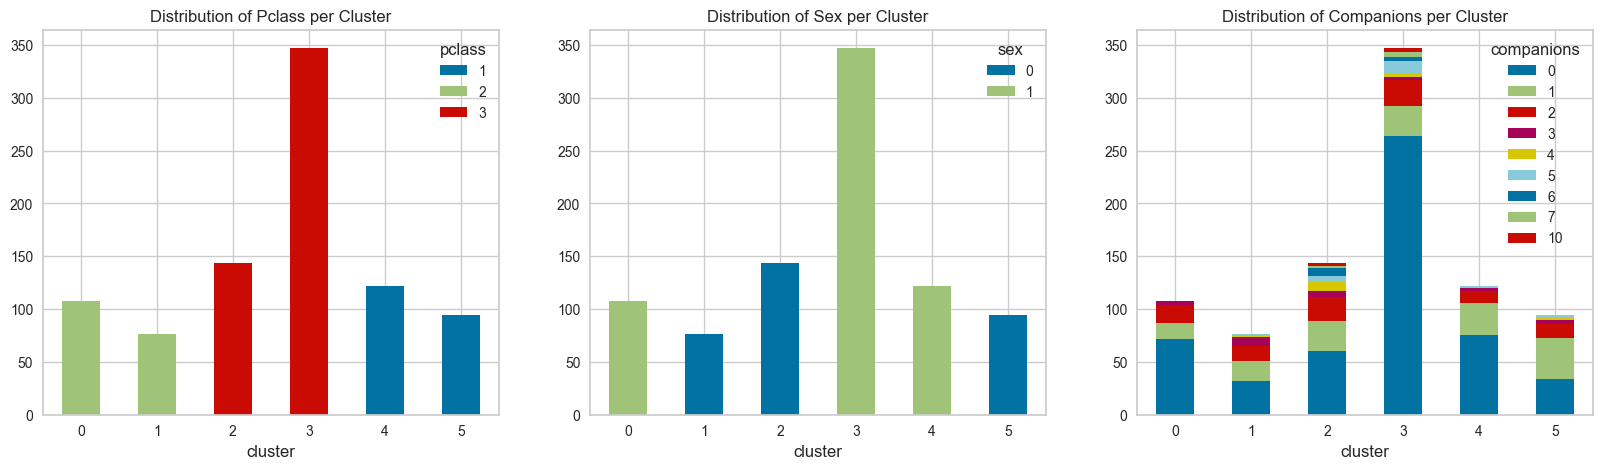

In [96]:
#  visualize main characteristics
fig, axs = plt.subplots(1, 3, figsize=(20,5))

col_list = ["pclass",
            "sex",
            "companions"]

for i, col in enumerate(col_list):
    pd.crosstab(titanic_kmeans_df["cluster"],
                titanic_kmeans_df[col]).plot.bar(stacked=True, 
                                                 ax=axs[i], 
                                                 rot=0)
    axs[i].set_title(f"Distribution of {col.capitalize()} per Cluster")
    
    plt.savefig("viz/categ_dist_cluster.png",
            bbox_inches="tight"
            )

,median,min,max
cluster,,,
0,31.0,0.67,70.0
1,28.0,2.00,57.0
2,18.0,0.75,63.0
3,26.0,0.42,74.0
4,40.0,0.92,80.0
5,35.0,2.00,63.0


,median,min,max
cluster,,,
0,13.00000,0.0000,73.5000
1,22.00000,10.5000,65.0000
2,12.47500,6.7500,69.5500
3,7.92500,0.0000,69.5500
4,41.26250,0.0000,512.3292
5,82.66455,25.9292,512.3292


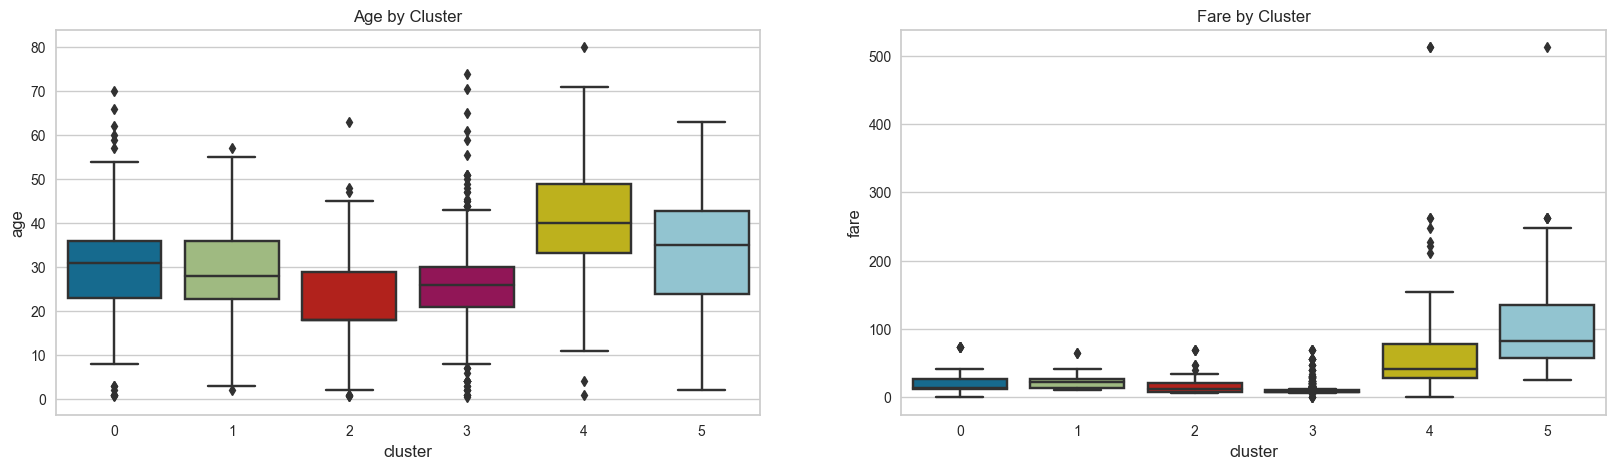

In [97]:
fig, axs = plt.subplots(1, 2, figsize=(20,5))

sns.boxplot(data=titanic_kmeans_df,
            x="cluster",
            y="age",
            ax=axs[0])
axs[0].set_title("Age by Cluster")

sns.boxplot(data=titanic_kmeans_df,
            x="cluster",
            y="fare",
            ax=axs[1])
axs[1].set_title("Fare by Cluster")

display(titanic_kmeans_df.groupby("cluster")["age"].agg(["median", "min", "max"]))
display(titanic_kmeans_df.groupby("cluster")["fare"].agg(["median", "min", "max"]))

plt.savefig("viz/numerical_dist_cluster.png",
            bbox_inches="tight"
            )

### Logistic Regression

#### Creating a copy of the original dataset

In [98]:
titanic_logreg_df = titanic_df.copy()
titanic_logreg_df.head()

,survived,pclass,name,sex,age,ticket,fare,title,embarked_C,embarked_Q,embarked_S,companions
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",1,22.0,A/5 21171,7.2500,Mr,0,0,1,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,PC 17599,71.2833,Mrs,1,0,0,1
3,1,3,"Heikkinen, Miss. Laina",0,26.0,STON/O2. 3101282,7.9250,Ms,0,0,1,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,113803,53.1000,Mrs,0,0,1,1
5,0,3,"Allen, Mr. William Henry",1,35.0,373450,8.0500,Mr,0,0,1,0


Logistic regression estimates the probability of an event occurring, such as voted or didn't vote, based on a given dataset of independent variables. For this case, survived and not survived. Note that the response variable would be the variable survived such that 0:= not survived and 1:= survived.

#### Feature selection 

In [99]:
X = titanic_logreg_df.drop(['survived','name','ticket','title'], axis=1)
y = titanic_logreg_df['survived']

#### Scaling features

In [100]:
#  standard scaling dataframe
standard = StandardScaler()
scaled_logreg = standard.fit_transform(X)
X = pd.DataFrame(scaled_logreg, columns=X.columns)
X.describe()

,pclass,sex,age,fare,embarked_C,embarked_Q,embarked_S,companions
count,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,891.000000,8.910000e+02,8.910000e+02
mean,-8.772133e-17,-1.156327e-16,3.987333e-17,3.987333e-18,-1.993666e-17,0.000000,-8.373399e-17,-3.987333e-18
std,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562,1.000562e+00,1.000562e+00
min,-1.566107e+00,-1.355574e+00,-2.129507e+00,-6.484217e-01,-4.820427e-01,-0.307562,-1.623803e+00,-5.609748e-01
25%,-3.693648e-01,-1.355574e+00,-6.037625e-01,-4.891482e-01,-4.820427e-01,-0.307562,-1.623803e+00,-5.609748e-01
50%,8.273772e-01,7.376951e-01,-2.330763e-01,-3.573909e-01,-4.820427e-01,-0.307562,6.158384e-01,-5.609748e-01
75%,8.273772e-01,7.376951e-01,5.638990e-01,-2.424635e-02,-4.820427e-01,-0.307562,6.158384e-01,5.915988e-02
max,8.273772e-01,7.376951e-01,3.770334e+00,9.667167e+00,2.074505e+00,3.251373,6.158384e-01,5.640372e+00


#### Train-Test split

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)

#### Logistic regression training

In [102]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train.values, y_train)
y_pred = log_reg.predict(X_test.values)

#### Evaluating the model

In [103]:
# Accuracy of the model
accuracy = accuracy_score(y_pred, y_test) * 100
print(f"The model is {accuracy:.2f}% accurate\n")
print(classification_report(y_test, y_pred))

confusion_logreg_df = pd.DataFrame(confusion_matrix(y_test, y_pred),
                                   columns=["True_pred", "False_pred"],
                                   index=["True_actual", "False_actual"])
print("\nConfusion Matrix")
display(confusion_logreg_df)

true_positive = confusion_logreg_df.loc["True_actual", "True_pred"]
true_negative = confusion_logreg_df.loc["False_actual", "False_pred"]
false_positive = confusion_logreg_df.loc["True_actual", "False_pred"]
false_negative = confusion_logreg_df.loc["False_actual", "True_pred"]

print(f"True positive: {true_positive}")
print(f"True negative: {true_negative}")
print(f"False positive: {false_positive}")
print(f"False negative: {false_negative}")

The model is 79.66% accurate

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       184
           1       0.74      0.71      0.72       111

    accuracy                           0.80       295
   macro avg       0.78      0.78      0.78       295
weighted avg       0.80      0.80      0.80       295


Confusion Matrix


,True_pred,False_pred
True_actual,156,28
False_actual,32,79


True positive: 156
True negative: 79
False positive: 28
False negative: 32


##### ROC curve

Train/Test split results:
LogisticRegression accuracy is 0.797
LogisticRegression log_loss is 0.446
LogisticRegression auc is 0.851


X has feature names, but LogisticRegression was fitted without feature names
color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.


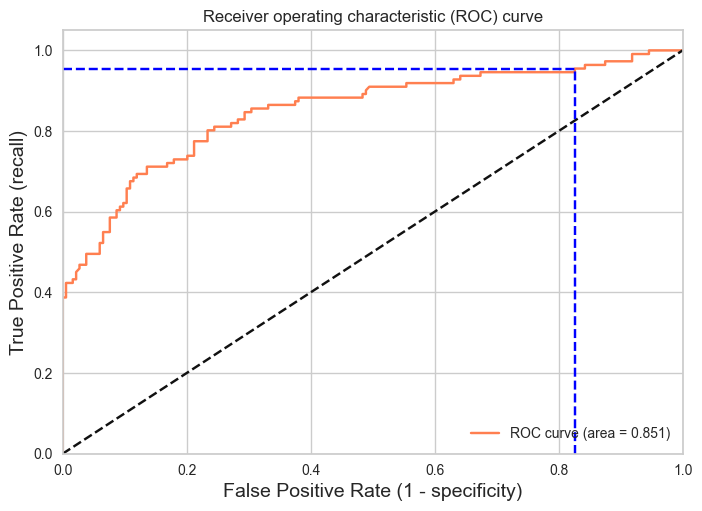

In [104]:
#Model Evaluation based on simple train/test split
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
print('Train/Test split results:')
print(log_reg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(log_reg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
print(log_reg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

idx = np.min(np.where(tpr > 0.95))

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

#### Feature importance

In [105]:
perm1 = PermutationImportance(log_reg, random_state=1).fit(X_test.values, y_test.values)
eli5.show_weights(perm1, feature_names = X_test.columns.tolist())

Weight,Feature
0.1959 ± 0.0599,sex
0.0956 ± 0.0262,pclass
0.0244 ± 0.0174,age
0.0156 ± 0.0308,companions
0 ± 0.0000,embarked_Q
-0.0014 ± 0.0069,embarked_S
-0.0020 ± 0.0069,fare
-0.0027 ± 0.0051,embarked_C


In [106]:
explainer = shap.KernelExplainer(log_reg.predict_proba, link='logit', data=X_train)
shap_values = explainer.shap_values(X_test)

Using 596 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/295 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


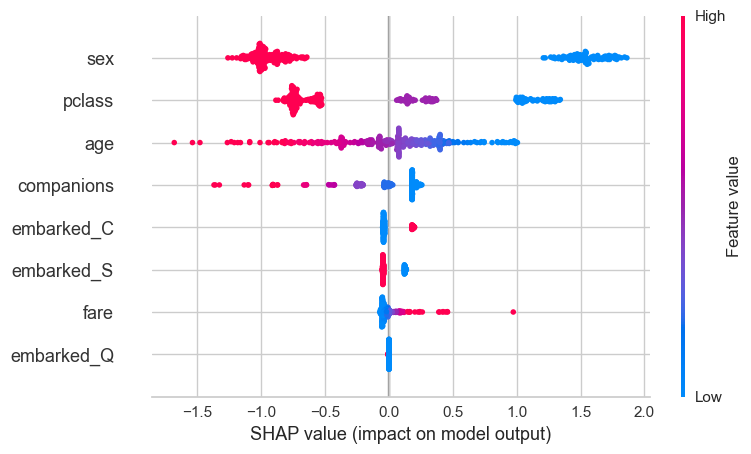

In [107]:
shap.summary_plot(shap_values[1], X_test)


###### References: Johari, N. (2013). Stress and Coping Strategies among Commuter and Non-commuter Students. ResearchGate. https://doi.org/10.13140//RG.2.2.19157.83688 & https://medium.datadriveninvestor.com/k-nearest-neighbors-in-python-hyperparameters-tuning-716734bc557f


### K-Nearest Neighbors

#### Creating a copy of the original dataset

In [108]:
titanic_knn_df = titanic_df.copy()
titanic_knn_df.head()

,survived,pclass,name,sex,age,ticket,fare,title,embarked_C,embarked_Q,embarked_S,companions
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",1,22.0,A/5 21171,7.2500,Mr,0,0,1,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,PC 17599,71.2833,Mrs,1,0,0,1
3,1,3,"Heikkinen, Miss. Laina",0,26.0,STON/O2. 3101282,7.9250,Ms,0,0,1,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,113803,53.1000,Mrs,0,0,1,1
5,0,3,"Allen, Mr. William Henry",1,35.0,373450,8.0500,Mr,0,0,1,0


#### Feature selection: only numerical features

In [109]:
X = titanic_knn_df.drop(['survived','name','ticket','title'], axis=1)
y = titanic_knn_df['survived']

#### Scaling features

In [110]:
#  minmax scaling dataframe
minmax = MinMaxScaler()
scaled_knn = minmax.fit_transform(X)
X = pd.DataFrame(scaled_knn, columns=X.columns)
X

,pclass,sex,age,fare,embarked_C,embarked_Q,embarked_S,companions
0,1.0,1.0,0.271174,0.014151,0.0,0.0,1.0,0.1
1,0.0,0.0,0.472229,0.139136,1.0,0.0,0.0,0.1
2,1.0,0.0,0.321438,0.015469,0.0,0.0,1.0,0.0
3,0.0,0.0,0.434531,0.103644,0.0,0.0,1.0,0.1
4,1.0,1.0,0.434531,0.015713,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
886,0.5,1.0,0.334004,0.025374,0.0,0.0,1.0,0.0
887,0.0,0.0,0.233476,0.058556,0.0,0.0,1.0,0.0
888,1.0,0.0,0.220910,0.045771,0.0,0.0,1.0,0.3
889,0.0,1.0,0.321438,0.058556,1.0,0.0,0.0,0.0


#### Train-Test split

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)

#### Hyperparameter tuning

In [112]:
#List Hyperparameters that we want to tune.
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]

#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

#Create new KNN object
knn = KNeighborsClassifier()

#Use GridSearch
clf = GridSearchCV(knn, hyperparameters, cv=10)

#Fit the model
best_model = clf.fit(X_train,y_train)

#Print The value of best Hyperparameters
print('Best leaf_size:', best_leaf := best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_p := best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_k := best_model.best_estimator_.get_params()['n_neighbors'])

Best leaf_size: 1
Best p: 1
Best n_neighbors: 7


#### KNN training

In [113]:
knn_clf = KNeighborsClassifier(n_neighbors=best_k, leaf_size=best_leaf, p=best_p, n_jobs=-1)
knn_clf.fit(X_train.values, y_train)
y_pred = knn_clf.predict(X_test.values)

###### Reference: https://medium.datadriveninvestor.com/k-nearest-neighbors-in-python-hyperparameters-tuning-716734bc557f

#### Evaluating the model

In [114]:
# Accuracy of the model
accuracy = accuracy_score(y_pred, y_test) * 100
print(f"The model is {accuracy:.2f}% accurate\n")
print(classification_report(y_test, y_pred))

confusion_knn_df = pd.DataFrame(confusion_matrix(y_test, y_pred),
                                   columns=["True_pred", "False_pred"],
                                   index=["True_actual", "False_actual"])
print("\nConfusion Matrix")
display(confusion_knn_df)

true_positive = confusion_knn_df.loc["True_actual", "True_pred"]
true_negative = confusion_knn_df.loc["False_actual", "False_pred"]
false_positive = confusion_knn_df.loc["True_actual", "False_pred"]
false_negative = confusion_knn_df.loc["False_actual", "True_pred"]

print(f"True positive: {true_positive}")
print(f"True negative: {true_negative}")
print(f"False positive: {false_positive}")
print(f"False negative: {false_negative}")

The model is 80.34% accurate

              precision    recall  f1-score   support

           0       0.83      0.86      0.84       184
           1       0.75      0.71      0.73       111

    accuracy                           0.80       295
   macro avg       0.79      0.79      0.79       295
weighted avg       0.80      0.80      0.80       295


Confusion Matrix


,True_pred,False_pred
True_actual,158,26
False_actual,32,79


True positive: 158
True negative: 79
False positive: 26
False negative: 32


##### ROC curve

Train/Test split results:
KNeighborsClassifier accuracy is 0.803
KNeighborsClassifier log_loss is 1.541
KNeighborsClassifier auc is 0.858


X has feature names, but KNeighborsClassifier was fitted without feature names
color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.


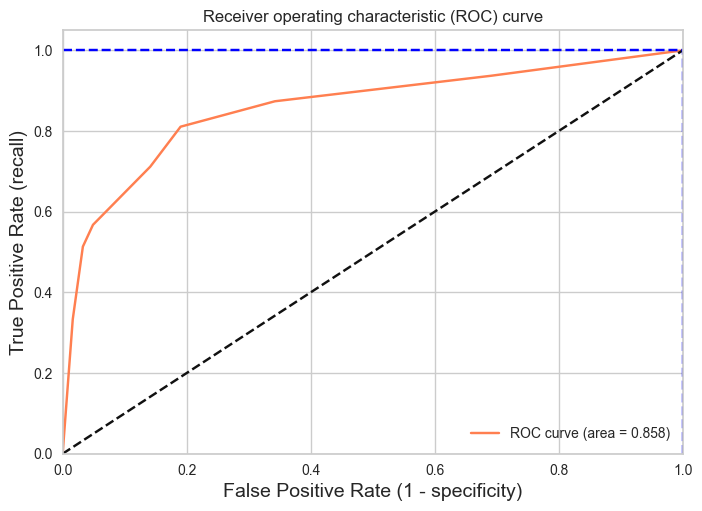

In [115]:
#Model Evaluation based on simple train/test split
y_pred_proba = knn_clf.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
print('Train/Test split results:')
print(knn_clf.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(knn_clf.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
print(knn_clf.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

idx = np.min(np.where(tpr > 0.95))

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

#### Feature importance

In [116]:
perm2 = PermutationImportance(knn_clf, random_state=1).fit(X_test.values, y_test)
eli5.show_weights(perm2, feature_names = X_test.columns.tolist())

Weight,Feature
0.2068 ± 0.0335,sex
0.0658 ± 0.0363,pclass
0.0136 ± 0.0074,fare
0.0095 ± 0.0100,companions
0.0068 ± 0.0433,age
0 ± 0.0000,embarked_Q
-0.0068 ± 0.0043,embarked_C
-0.0081 ± 0.0054,embarked_S


##### SHAP

In [117]:
explainer = shap.KernelExplainer(knn_clf.predict_proba, data=X_train)
shap_values = explainer.shap_values(X_test.values)

Using 596 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/295 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


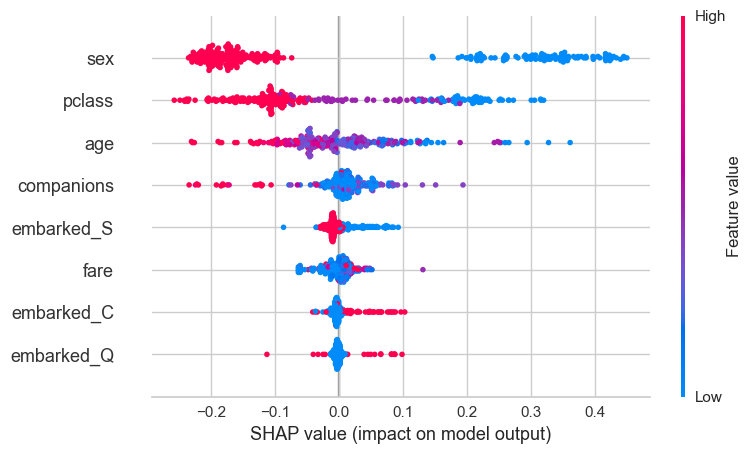

In [118]:
shap.summary_plot(shap_values[1], X_test)